In [31]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import timeit

# Problem 1

In [6]:
# 读取数据并删除缺失值
rets = pd.read_csv("DailyReturn.csv")
rets = rets.dropna(subset=['SPY'])
rets = rets.iloc[:,1:]
rets

,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,-0.003269,0.001423,-0.000136,0.012222,0.018326,0.009260,0.008723,-0.008426,0.013278,-0.015228,...,-0.013455,-0.008396,-0.005559,0.000520,-0.015466,-0.023272,-0.004768,-0.008806,-0.009122,-0.010335
1,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028571,0.013237
2,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,-0.001739,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025983
3,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,-0.006653,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030856,-0.031925,-0.033380,-0.028763
4,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,0.003987,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,-0.010629,0.024400,-0.023621,-0.084315,0.009083,-0.027474,-0.032904,-0.011866,-0.028053,-0.010742,...,-0.004694,-0.011251,-0.001277,-0.002677,0.038211,0.004134,0.002336,-0.008916,-0.005954,0.001617
245,-0.006111,-0.017929,-0.006116,-0.011703,0.025161,-0.017942,-0.016632,-0.002520,-0.000521,-0.000259,...,-0.014451,0.003945,0.001066,-0.007102,0.022012,0.021826,-0.041181,0.005106,-0.009782,-0.004595
246,0.013079,0.019245,0.042022,-0.000685,0.010526,0.046064,0.044167,0.029883,0.051401,0.014720,...,-0.000368,-0.016473,-0.008518,0.019544,-0.003590,-0.001641,0.003573,0.001451,0.008669,-0.003618
247,-0.010935,-0.017653,-0.003102,-0.020174,0.022763,-0.076830,-0.074417,-0.042741,0.001443,-0.014346,...,-0.008469,-0.004456,-0.001289,-0.018009,-0.004416,0.002819,-0.015526,0.004106,-0.015391,0.009363


In [8]:
# 数据类型转换
for col in rets.columns:
    if rets[col].dtype == 'object':
        print(f"Running {col}")
        rets[col] = rets[col].astype(float)

In [9]:
# 指数加权协方差函数
def ewCovar(x, lbda):
    m, n = x.shape
    w = (1 - lbda) * lbda ** np.arange(m)[::-1]
    w /= w.sum()
    xm = x - x.mean()
    return np.cov(xm, aweights=w, rowvar=False)

In [23]:
# PCA 百分比解释函数
def PCA_pctExplained(covar):
    pca = PCA()
    pca.fit(covar)
    explained_var = np.cumsum(pca.explained_variance_ratio_)
    return explained_var

# 手动计算
# def PCA_pctExplained_manual(covar):
#     # 计算特征值和特征向量
#     eig_vals, eig_vecs = np.linalg.eig(covar)
    
#     # 对特征值进行降序排序
#     eig_vals_sorted_indices = np.argsort(eig_vals)[::-1]
#     eig_vals_sorted = eig_vals[eig_vals_sorted_indices]
    
#     # 计算总的特征值
#     total_eig_vals = sum(eig_vals_sorted)
    
#     # 计算每个主成分解释的方差百分比
#     var_exp = [(i / total_eig_vals) for i in eig_vals_sorted]
#     cum_var_exp = np.cumsum(var_exp)  # 累积方差百分比
    
#     return cum_var_exp

In [24]:
# 测试函数
lbda_values = [0.75, 0.85, 0.90, 0.95, 0.99]
pctExplained = pd.DataFrame()

for lbda in lbda_values:
    covar = ewCovar(rets.values, lbda)
    expl = PCA_pctExplained(covar)
    pctExplained[f"lambda={lbda}"] = expl[:rets.shape[1]]

In [25]:
pctExplained

,lambda=0.75,lambda=0.85,lambda=0.9,lambda=0.95,lambda=0.99
0,0.863435,0.860205,0.842046,0.818796,0.875097
1,0.919182,0.917222,0.905260,0.888925,0.907047
2,0.958614,0.948543,0.935473,0.926667,0.927426
3,0.976314,0.968948,0.956099,0.943272,0.939297
4,0.988776,0.979518,0.972107,0.957376,0.949445
...,...,...,...,...,...
95,1.000000,1.000000,1.000000,1.000000,1.000000
96,1.000000,1.000000,1.000000,1.000000,1.000000
97,1.000000,1.000000,1.000000,1.000000,1.000000
98,1.000000,1.000000,1.000000,1.000000,1.000000


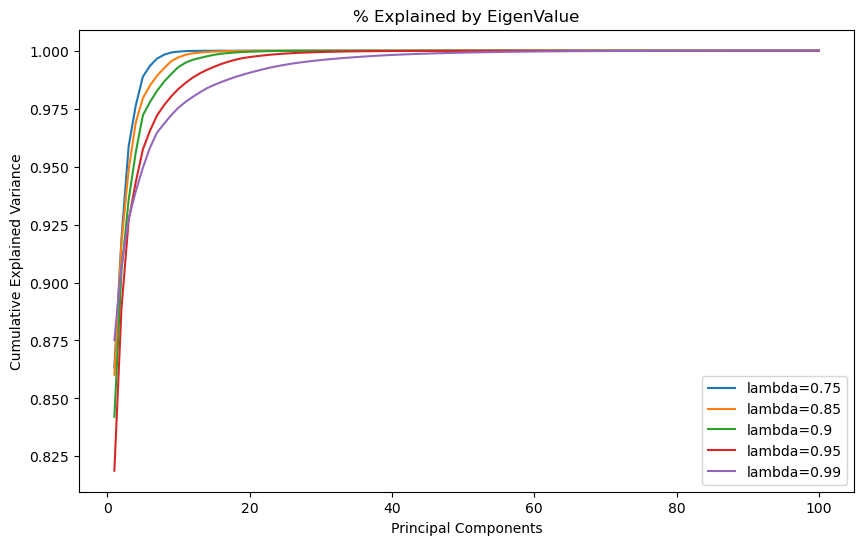

In [26]:
# 绘图
plt.figure(figsize=(10, 6))
for col in pctExplained.columns:
    plt.plot(pctExplained.index + 1, pctExplained[col], label=col)
plt.legend(loc='lower right')
plt.title("% Explained by EigenValue")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

As lambda descreases, the percent explained by the first eigenvalues increases. This is because more weight is added to the more recent observations. The lower the lambda, the lower the rank of the matrix 意味着独立的col越少，能被PCA解释的越多

# Problem 2

In [41]:
def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    invSD = None

    # 如果 a 不是相关矩阵，则转换为相关矩阵
    if not np.allclose(np.diag(a), 1):
        invSD = np.diag(1.0 / np.sqrt(np.diag(a)))
        a = np.dot(invSD, a).dot(invSD)

    # 计算特征值和特征向量
    vals, vecs = np.linalg.eigh(a)
    
    # 修正特征值
    vals = np.maximum(vals, epsilon)
    
    # 计算 T
    T = 1.0 / np.dot(vecs**2,vals)
    T = np.diag(T)
    
    # 计算 l
    l = np.diag(np.sqrt(vals))
    
    # 计算 B
    B = T.dot(vecs).dot(l)
    
    # 计算近似 PSD 矩阵
    a_psd = B.dot(B.T)
    
    # 如果之前转换了相关矩阵，则反转这个转换
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        a_psd = invSD.dot(a_psd).dot(invSD)

    return a_psd

In [56]:
def chol_psd(root, a):
    n = a.shape[0]  # 获取矩阵a的行数
    root.fill(0)  # 将root矩阵初始化为全0矩阵

    for j in range(n):  # 对于矩阵a的每一列进行循环
        s = 0.0
        if j > 0:  # 如果不是第一列，需要计算之前列的点积
            s = np.dot(root[j, :j], root[j, :j])

        temp = a[j, j] - s
        if 0 >= temp >= -1e-8:  # 如果temp的值接近0，则设置为0
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        if root[j, j] == 0.0:  # 如果对角元素为0，即当前列全为0
            root[(j+1):n,j] = 0.0
        else:
            ir = 1.0 / root[j, j]
            for i in range(j+1, n):
                s = np.dot(root[i, :j], root[j, :j].T)
                root[i, j] = (a[i, j] - s) * ir

In [43]:
# Helper Function
def _getAplus(A):
    vals, vecs = np.linalg.eigh(A)
    vals = np.diag(np.maximum(vals, 0))
    return np.dot(vecs, np.dot(vals, vecs.T))

def _getPS(A, W):
    W05 = np.sqrt(W)
    iW05 = np.linalg.inv(W05)
    return np.dot(iW05, np.dot(_getAplus(np.dot(W05, np.dot(A, W05))), iW05))

def _getPu(A, W):
    Aret = A.copy()
    np.fill_diagonal(Aret, 1)
    return Aret

def wgtNorm(A, W):
    W05 = np.sqrt(W)
    WA = W05.dot(A).dot(W05)
    W_norm = np.sum(WA**2)
    return np.sum(W_norm)

In [44]:
# pc means pearson correlation
def higham_nearestPSD(pc, W=None, epsilon=1e-9, maxIter=100, tol=1e-9):
    n = pc.shape[0]
    if W is None:
        W = np.diag(np.ones(n))
    
    Yk = pc.copy()
    norml = np.inf
    i = 1

    while i <= maxIter:
        Rk = Yk - deltaS if i > 1 else Yk
        Xk = _getPS(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)
        norm = wgtNorm(Yk - pc, W)
        minEigVal = np.min(np.real(np.linalg.eigvals(Yk)))

        if abs(norm - norml) < tol and minEigVal > -epsilon:
            break

        norml = norm
        i += 1

    if i < maxIter:
        print("Converged in {} iterations.".format(i))
    else:
        print("Convergence failed after {} iterations".format(i - 1))

    return Yk

In [45]:
def generate_sigma(n):
    sigma = np.full((n, n), 0.9)
    np.fill_diagonal(sigma, 1.0)
    sigma[1, 2] = sigma[2, 1] = 0.7357
    return sigma

def evaluate_methods(n):
    sigma = generate_sigma(n)
    W = np.eye(n)  # Identity matrix as weight

    hpsd = higham_nearestPSD(sigma)
    npsd = near_psd(sigma)

    norm_hpsd = wgtNorm(hpsd - sigma, W)
    norm_npsd = wgtNorm(npsd - sigma, W)

    print(f"n={n}")
    print(f"Distance near_psd()={norm_npsd}")
    print(f"Distance higham_nearestPSD()={norm_hpsd}")

    higham_time = timeit.timeit(lambda: higham_nearestPSD(sigma), number=10) / 10
    near_psd_time = timeit.timeit(lambda: near_psd(sigma), number=10) / 10

    print(f"Higham Took: {higham_time} seconds")
    print(f"Near_PSD Took: {near_psd_time} seconds")

evaluate_methods(500)
evaluate_methods(1000)

Converged in 26 iterations.
n=500
Distance near_psd()=1.5387598238598055
Distance higham_nearestPSD()=0.008036763056468877
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Higham Took: 12.48772064000077 seconds
Near_PSD Took: 0.046455720000085424 seconds
Converged in 26 iterations.
n=1000
Distance near_psd()=3.110427568520044
Distance higham_nearestPSD()=0.008152133421029228
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Converged in 26 iterations.
Higham Took: 32.54825473000092 seconds
Near_PSD Took: 0.32143781000049787 seconds


# Problem 3

In [46]:
import numpy.random as npr
from scipy.stats import norm
# from scipy.linalg import cholesky

In [61]:
def simulate_normal(N, cov, mean=None, seed=1234):
    n = cov.shape[0]
    if cov.shape[1] != n:
        raise ValueError(f"Covariance matrix is not square ({n},{cov.shape[1]})")

    if mean is None:
        mean = np.zeros(n)
    elif mean.shape[0] != n:
        raise ValueError(f"Mean ({mean.shape[0]}) is not the size of cov ({n},{n})")

    # Take the root of the covariance matrix
    l = np.zeros([n,n])
    chol_psd(l, cov)  

    # Generate needed random standard normals
    npr.seed(seed)
    out = npr.standard_normal((N, n))

    # Apply the Cholesky root to the standard normals
    out = np.dot(out, l.T)

    # Add the mean
    out += mean

    return out

In [84]:
def simulate_pca(a, nsim, pctExp=1, mean=None, seed=1234):
    n = a.shape[0]

    if mean is None:
        mean = np.zeros(n)
    elif mean.shape[0] != n:
        raise ValueError(f"Mean size {mean.shape[0]} does not match covariance size {n}.")

    # Eigenvalue decomposition
    vals, vecs = np.linalg.eigh(a)
    vals = np.real(vals)
    vecs = np.real(vecs)
    # Sort eigenvalues and eigenvectors
    idx = vals.argsort()[::-1]
    vals = vals[idx]
    vecs = vecs[:, idx]

    # Calculate total variance
    tv = np.sum(vals)

    # Select principal components based on pctExp
    cum_var_exp = np.cumsum(vals) / tv
    if pctExp < 1:
        n_components = np.searchsorted(cum_var_exp, pctExp) + 1 # 这个函数在cum_var_exp数组中查找pctExp应该插入的位置
        vals = vals[:n_components]
        vecs = vecs[:, :n_components]
    else:
        n_components = n
    # Construct principal component matrix
    B = vecs @ np.diag(np.sqrt(vals))

    # Generate random samples
    np.random.seed(seed)
    r = np.random.randn(n_components, nsim)
    out = (B @ r).T

    # Add the mean
    out += mean

    return out

In [77]:
# 初始化协方差矩阵
pearson_cov = np.cov(rets.T)
pearson_std = np.sqrt(np.diag(pearson_cov))
pearson_cor = np.corrcoef(rets.T)

ewma_cov = ewCovar(rets.values, 0.97)
ewma_std = np.sqrt(np.diag(ewma_cov))
ewma_cor = np.diag(1 / ewma_std) @ ewma_cov @ np.diag(1 / ewma_std)

In [85]:
import time

matrixType = ["EWMA", "EWMA_COR_PEARSON_STD", "PEARSON", "PEARSON_COR_EWMA_STD"]
simType = ["Full", "PCA=1", "PCA=0.75", "PCA=0.5"]

# 变回了covariance
matrix_lookup = {
    "EWMA": ewma_cov,
    "EWMA_COR_PEARSON_STD": np.diag(pearson_std) @ ewma_cor @ np.diag(pearson_std),
    "PEARSON": pearson_cov,
    "PEARSON_COR_EWMA_STD": np.diag(ewma_std) @ pearson_cor @ np.diag(ewma_std)
}

results = []

# 执行模拟
for sim in simType:
    for mat in matrixType:
        c = matrix_lookup[mat]
        start_time = time.time()
        
        if sim == "Full":
            for _ in range(20):
                s = simulate_normal(25000, c)
        else:
            pctExp = float(sim.split('=')[1])
            for _ in range(20):
                s = simulate_pca(c, 25000, pctExp=pctExp)

        elapse = (time.time() - start_time) / 20
        covar = np.cov(s.T)
        norm = np.sum((covar - c) ** 2)

        results.append({
            "Matrix": mat,
            "Simulation": sim,
            "Runtime": elapse,
            "Norm": norm
        })

out_table = pd.DataFrame(results)

In [86]:
out_table

,Matrix,Simulation,Runtime,Norm
0,EWMA,Full,0.109752,4.145352e-04
1,EWMA_COR_PEARSON_STD,Full,0.123760,5.894048e-04
2,PEARSON,Full,0.120932,7.459526e-04
3,PEARSON_COR_EWMA_STD,Full,0.118820,5.295169e-04
4,EWMA,PCA=1,0.092463,6.523482e-08
5,EWMA_COR_PEARSON_STD,PCA=1,0.092598,9.759808e-08
6,PEARSON,PCA=1,0.090209,9.050307e-08
7,PEARSON_COR_EWMA_STD,PCA=1,0.092975,6.151422e-08
8,EWMA,PCA=0.75,0.022378,3.529618e-06
9,EWMA_COR_PEARSON_STD,PCA=0.75,0.023599,5.196451e-06
